# Определение возраста покупателей

## Импорт библиотек

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

RS=42

## Исследовательский анализ данных

Загрузка датасета в экземпляр класса `ImageDataGenerator`.

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
train = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=RS)

Found 7591 validated image filenames.


In [4]:
labels.shape

(7591, 2)

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Мы имеем 7591 фотографию лиц людей с метками возраста. Взглянем, как распределен возраст людей в нашей выборке.

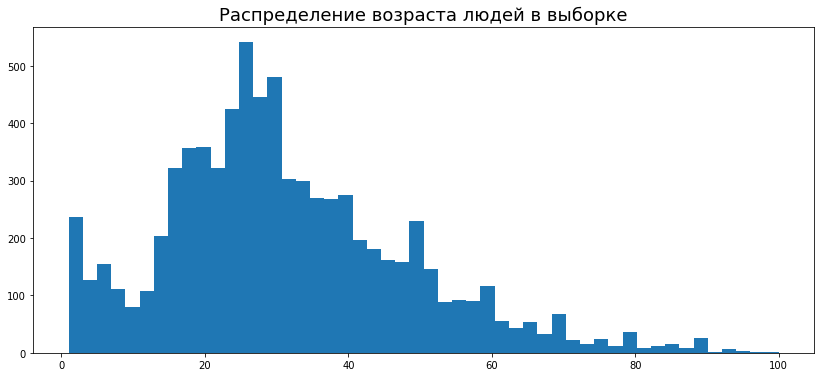

In [5]:
plt.figure(figsize=(14,6))
plt.hist(labels['real_age'],
         bins=50)
plt.title('Распределение возраста людей в выборке', fontsize=18);

**Вывод:**
* Больше всего фотографий представлены для возрастной категории от 15 до 50 лет;
* Самому молодому человеку 1 год, самому старому 100 лет;
* Средний и медианный возраст выборки около 30 лет;
* Гистограмма имеет длинный хвост справа, что связано с плавным уменьшением количества долгожителей:
    * Людей старше 70 лет десятки;
    * Старше 90 лет единицы.

Также взглянем на 16 случайных фотографий из разных батчей нашего генератора, чтобы понимать - с каким именно данными работаем.

CPU times: user 3.25 s, sys: 296 ms, total: 3.55 s
Wall time: 24.5 s


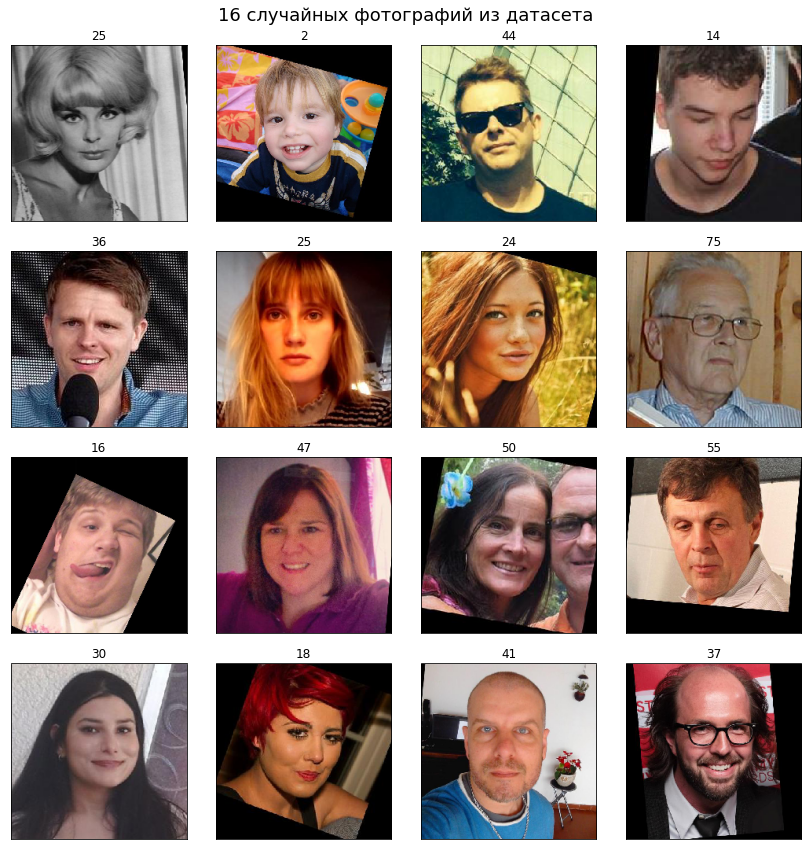

In [7]:
%%time
fig = plt.figure(figsize=(12, 12))
plt.suptitle('16 случайных фотографий из датасета',
             fontsize=18)
for i in range(16):
    image, label = train.next()
    random_pict = int(np.random.randint(0, 31, 1))
    fig.add_subplot(4, 4, i+1)
    plt.imshow(image[random_pict])
    plt.title(label[random_pict])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:**
* Фотографии уже предобработаны и аугментированы (есть повороты, искажения);
* Фотографии разного качества, цветовой палитры и сделаны в разных условиях освещения, что хорошо для обучения модели;
* В датасете преобладают люди от 15 до 50 лет;
* Имеются провалы в категории около 10 лет и, конечно, для людей старше 70 лет: уже можем предположить, что пожилых людей модель будет распознавать хуже, так как мало обучающих данных.


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

RS=42

def load_train(path):
    
    labels = pd.read_csv(path + '/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)
    train = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=RS)
    
    return train


def load_test(path):
    
    labels = pd.read_csv(path + '/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)
    test = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=RS)

    return test


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', 
                  optimizer=optimizer, 
                  metrics=[MeanAbsoluteError()])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
     
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```
Found 6073 validated image filenames.
Found 1518 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>


Train for 190 steps, validate for 48 steps
Epoch 1/10
190/190 - 47s - loss: 213.5324 - mean_absolute_error: 10.4407 - val_loss: 761.5377 - val_mean_absolute_error: 22.5247
Epoch 2/10
190/190 - 38s - loss: 56.8983 - mean_absolute_error: 5.7411 - val_loss: 593.5265 - val_mean_absolute_error: 19.0623
Epoch 3/10
190/190 - 38s - loss: 28.3238 - mean_absolute_error: 4.0878 - val_loss: 311.9656 - val_mean_absolute_error: 12.9676
Epoch 4/10
190/190 - 38s - loss: 17.5532 - mean_absolute_error: 3.2382 - val_loss: 101.6078 - val_mean_absolute_error: 7.5731
Epoch 5/10
190/190 - 38s - loss: 14.5096 - mean_absolute_error: 2.9592 - val_loss: 87.8235 - val_mean_absolute_error: 6.9878
Epoch 6/10
190/190 - 38s - loss: 10.3230 - mean_absolute_error: 2.4506 - val_loss: 73.6633 - val_mean_absolute_error: 6.3983
Epoch 7/10
190/190 - 38s - loss: 8.5108 - mean_absolute_error: 2.1825 - val_loss: 67.3240 - val_mean_absolute_error: 6.1151
Epoch 8/10
190/190 - 38s - loss: 7.4038 - mean_absolute_error: 2.0667 - val_loss: 64.5185 - val_mean_absolute_error: 6.1348
Epoch 9/10
190/190 - 38s - loss: 6.6439 - mean_absolute_error: 1.9363 - val_loss: 68.9294 - val_mean_absolute_error: 6.3589
Epoch 10/10
190/190 - 38s - loss: 6.3781 - mean_absolute_error: 1.8641 - val_loss: 62.4301 - val_mean_absolute_error: 5.8707
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 62.4301 - mean_absolute_error: 5.8707
Test MAE: 5.8707

```

## Анализ обученной модели

Для задачи регрессии в текущем проекте была выбрана предобученная нейросеть ResNet из 50 слоёв - **ResNet50**. Обучение происходило на видеокарте Tesla V100 SXM2 с 32Gb памяти.

* Инициация сети происходила с весами, полученными после обучение на датасете ImageNet;
* Вместо двух оригинальных выходных слоёв (Average Pooling и Fully Connected на 1000 классов) были добавлены 3 слоя:
    * Average Pooling;
    * Полносвязный слой на 64 нейрона с ReLu-активацией;
    * Полносвязный слой с 1 нейроном с ReLu-активацией.
* Функция потерь - MSE; оптимизатор - Adam с learning rate=0.0001;
* Метрика качества - MAE;


Модель обучалась в течение 10 эпох батчами по 32 фотографии и **достигла MAE = 5,87 лет** на валидационной (и на тестовой) выборках. Время обучения - около 6,5 минут.

**Ценность для бизнеса:**
Заказчик хотел решить 2 задачи:
1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
1. Контролировать добросовестность кассиров при продаже алкоголя.

Ошибка в 6 лет некритична для рекомендаций товаров по возрастной группе, так что первая задача достигнута.
Вторая задача более сложная и строгая. Учитывая размер ошибки, можем доверять решению модели, когда она даёт оценку человеку 24 и более лет - тогда с высокой вероятностью покупателю уже есть 18 лет.